In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import sys
sys.path.append("../")

In [151]:
import numpy as np
import pandas as pd
from dowhy import gcm, CausalModel
import matplotlib.pyplot as plt
import rasterio

from sklearn.metrics import f1_score, accuracy_score
from src.causal_graph import create_causasl_graph_without_FFMC, create_exposition_forest_type_causal_graph, create_simplified_causal_graph
from src.utils import save_model, load_model

In [68]:
# read in training data
path_to_train_data = r"../data/data_prep/data_train.csv"
train_data = pd.read_csv(path_to_train_data)

/home/david/miniconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_model.py:582: UserWarning: 3 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


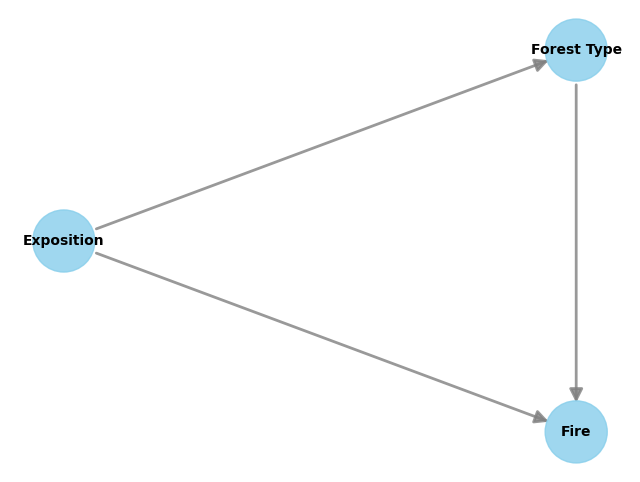

In [19]:
causal_graph = create_exposition_forest_type_causal_graph()
model = CausalModel(
    data=train_data,
    treatment="forest_type",
    outcome="fire",
    graph=causal_graph)
model.view_model()

/home/david/miniconda3/envs/causal_inference/lib/python3.9/site-packages/dowhy/causal_model.py:582: UserWarning: 4 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


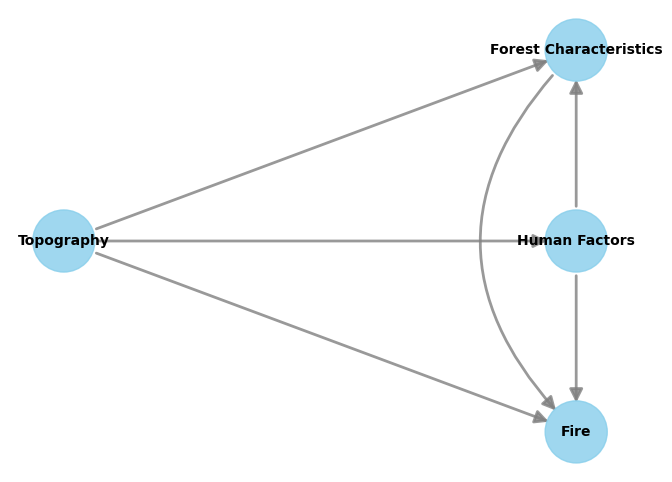

In [71]:
causal_graph = create_simplified_causal_graph()
model = CausalModel(
    data = train_data,
    treatment = "Topography",
    outcome = "Fire",
    graph = causal_graph
)
model.view_model()

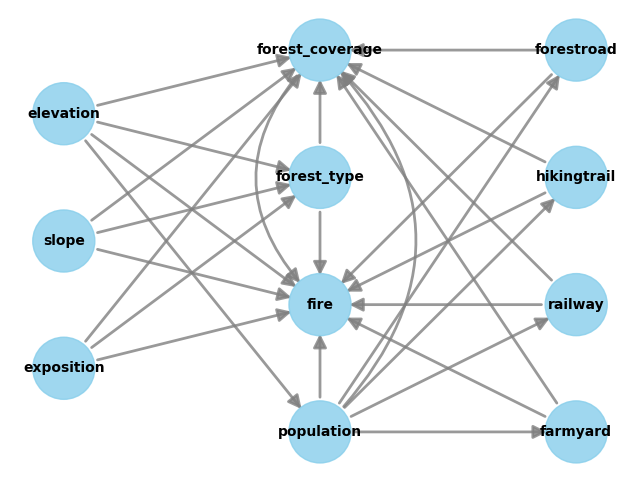

In [66]:
causal_graph = create_causasl_graph_without_FFMC()
model = CausalModel(
    data=train_data,
    treatment="forest_type",
    outcome="fire",
    graph=causal_graph)
model.view_model()

### Create the causal model

In [21]:
causal_graph = create_causasl_graph_without_FFMC()
causal_model = gcm.ProbabilisticCausalModel(causal_graph)

In [22]:
causal_mechanisms_summary = gcm.auto.assign_causal_mechanisms(causal_model, train_data)

In [23]:
gcm.fit(causal_model, train_data)

Fitting causal mechanism of node farmyard: 100%|██████████| 11/11 [00:02<00:00,  3.67it/s]      


In [24]:
summary_evaluation = gcm.evaluate_causal_model(causal_model, train_data, compare_mechanism_baselines=True)

Evaluating causal mechanisms...: 100%|██████████| 11/11 [00:00<00:00, 720.30it/s]


KeyboardInterrupt: 

In [ ]:
save_model(r"../models/model_without_FFMC.pkl", causal_model, causal_mechanisms_summary, summary_evaluation)

In [ ]:
print(causal_mechanisms_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

### Causal Tasks

In [30]:
causal_model, causal_mechanisms_summary, summary_evaluation = load_model(r"../models/model_without_FFMC.pkl")

#### Estimating Effect: Quanitifying Arrow Strength

In [39]:
def plot_with_confidence(data, confidence_intervals):
    fig, ax = plt.subplots(figsize=(8, 6))

    x = np.arange(len(data))
    y = [data[key] for key in data]
    #y_err = [confidence_intervals[key] for key in confidence_intervals]

    #ax.bar(x, y, yerr=np.abs(np.array(y_err).T - np.array(y)), align='center', alpha=0.5, ecolor='black', capsize=5)
    ax.bar(x, y, align='center', alpha=0.5, ecolor='black', capsize=5)
    ax.set_xticks(x)
    ax.set_xticklabels([key[0] for key in data.keys()], rotation=45)
    ax.set_ylabel('Values')
    ax.set_title('Arrow Strength of Factors')
    ax.yaxis.grid(True)

    plt.tight_layout()
    plt.savefig(r"../results/direct_causal_impact_without_FFMC.png")
    plt.show()

In [34]:
strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.arrow_strength,
                           causal_model,
                           target_node='fire', 
                           parent_samples=train_data))

Estimating bootstrap interval...:   0%|          | 0/20 [00:00<?, ?it/s]

TypeError: arrow_strength() got an unexpected keyword argument 'num_samples_to_draw'

In [42]:
print(strength_median)
#print(strength_intervals)

{('elevation', 'fire'): 0.03809273983922553, ('exposition', 'fire'): 0.06921671752502691, ('farmyard', 'fire'): 0.0, ('forest_coverage', 'fire'): 0.018541476303231236, ('forest_type', 'fire'): 0.09115129246305531, ('forestroad', 'fire'): 0.010274657040567854, ('hikingtrail', 'fire'): 0.057814873162617, ('population', 'fire'): 0.3292546608127151, ('railway', 'fire'): 0.020859656921767108, ('slope', 'fire'): 0.04426033776221426}


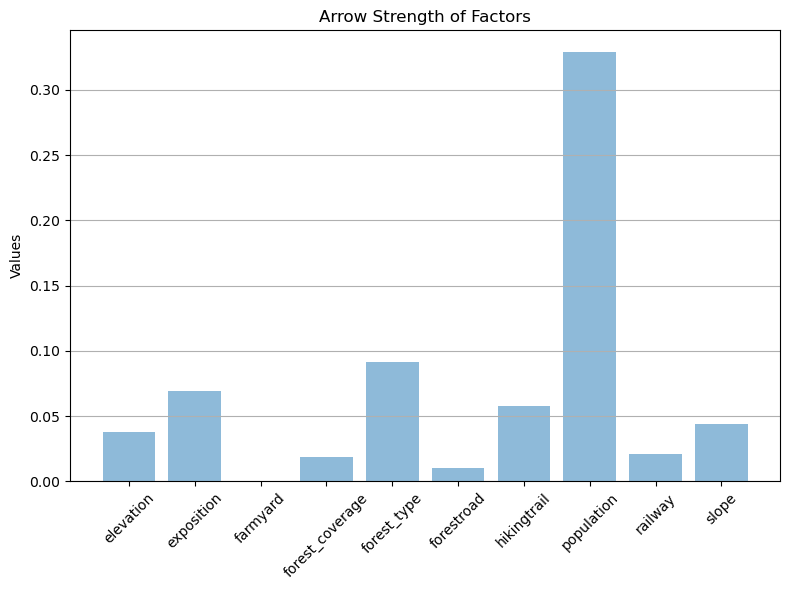

In [40]:
plot_with_confidence(strength_median, strength_intervals)

In [44]:
train_data.population.unique()

array(['0', '0-50 P/km2', '>1000 P/km2', '100-500 P/km2', '50-100 P/km2',
       '500-1000 P/km2'], dtype=object)

#### ACE of forest type, exposition and population
The impact mediated over one of the other factors should be eliminated

In [49]:
forest_cover_classes = ["cc<=20", "20<cc<=40", "40<cc<=60", "60<cc<=80", "cc>80"]
exposition_classes = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
forest_type_classes = ["coniferous non pine", "coniferous with mixed pine", "pine pure", 
                      "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"]
population_classes = ['0', '0-50 P/km2', '50-100 P/km2', '100-500 P/km2', '500-1000 P/km2', '>1000 P/km2']


def construct_ate_dict(exposition_classes, ref_value):
    ate_dict = {"ref_value": ref_value, "ate": {}}  
    for region in exposition_classes:
        ate_dict["ate"][region] = {}
    return ate_dict

def get_ate_with_confidence_for_factor_classes(ate_dict: dict, factor_name: str, causal_model):
    for cl in ate_dict["ate"].keys():
        effect_median, effect_interval = gcm.confidence_intervals(
            gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                causal_model, "fire", 
                                interventions_alternative={factor_name: lambda x: cl},
                                interventions_reference={factor_name: lambda x: ate_dict["ref_value"]}, 
                                num_samples_to_draw=1000))
        ate_dict["ate"][cl]["median"] = effect_median[0]
        ate_dict["ate"][cl]["interval"] = effect_interval[0]
    return ate_dict

def plot_ate_with_confidence(ate_data, path_to_fig: str):
    regions = list(ate_data['ate'].keys())
    ate_values = [ate_data['ate'][region]['median'] for region in regions]
    lower_bounds = [ate_data['ate'][region]['interval'][0] for region in regions]
    upper_bounds = [ate_data['ate'][region]['interval'][1] for region in regions]

    fig, ax = plt.subplots()
    y_pos = np.arange(len(regions))


    ax.errorbar(ate_values, y_pos, xerr=[np.array(ate_values) - np.array(lower_bounds), np.array(upper_bounds) - np.array(ate_values)],
                fmt='o', color='black', capsize=5, markersize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(regions)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.set_xlabel('ACE')
    ax.set_title('Average Causal Effect (ACE) with Confidence Intervals')
    plt.tight_layout()
    plt.savefig(path_to_fig)
    plt.show()


##### ACE of population

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


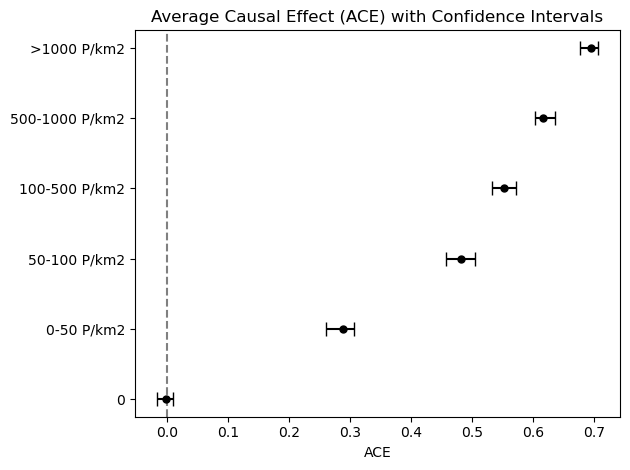

In [63]:
ate_dict_population = construct_ate_dict(population_classes, "0")

for pop in population_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'population': lambda x: pop,
                                                               'forest_coverage': lambda x: '40<cc<=60'},
                                    interventions_reference={'population': lambda x: ate_dict_population["ref_value"], 
                                                             'forest_coverage': lambda x: '40<cc<=60'},
                                    observed_data=train_data))
    
    ate_dict_population["ate"][pop]["median"] = effect_median[0]
    ate_dict_population["ate"][pop]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_population, r"../results/ate_population_without_FFMC.png")

##### ACE of exposition

Estimating bootstrap interval...:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s]


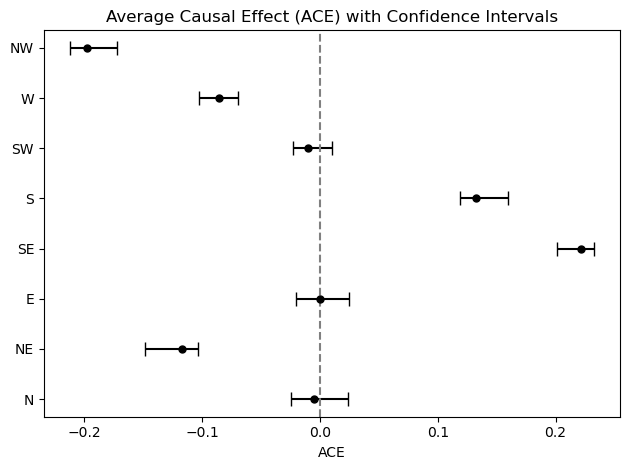

In [64]:
ate_dict_exposition = construct_ate_dict(exposition_classes, "E")

for exp in exposition_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'exposition': lambda x: exp, 
                                                        'forest_type': lambda x: "pine pure", 
                                                        'forest_coverage': lambda x: "40<cc<=60"},
                                    interventions_reference={'exposition': lambda x: ate_dict_exposition["ref_value"], 
                                                    'forest_type': lambda x: "pine pure",
                                                    'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=train_data))
    
    ate_dict_exposition["ate"][exp]["median"] = effect_median[0]
    ate_dict_exposition["ate"][exp]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_exposition, r"../results/ate_exposition_without_FFMC.png")

##### ACE for forest type

Estimating bootstrap interval...:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


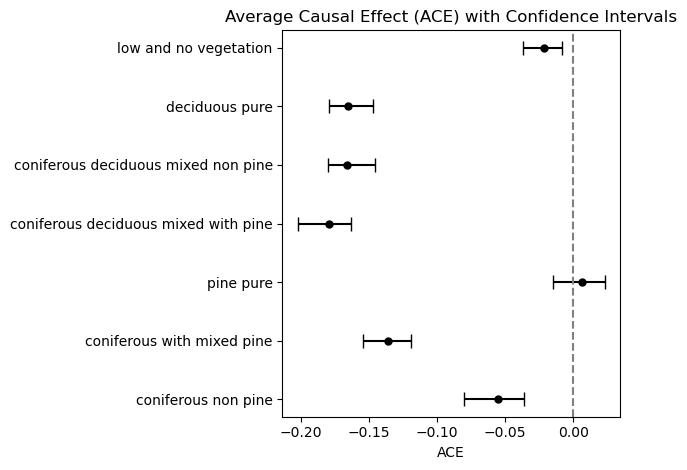

In [65]:
ate_dict_foresttype = construct_ate_dict(forest_type_classes, "pine pure")

for ft in forest_type_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'forest_type': lambda x: ft, 
                                                        'forest_coverage': lambda x: "40<cc<=60"},
                                    interventions_reference={'forest_type': lambda x: ate_dict_foresttype["ref_value"], 
                                                    'forest_coverage': lambda x: "40<cc<=60"},
                                    observed_data=train_data))
    
    ate_dict_foresttype["ate"][ft]["median"] = effect_median[0]
    ate_dict_foresttype["ate"][ft]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_foresttype, r"../results/ate_forest_type_without_FFC.png")

##### ACE for forest coverage

Estimating bootstrap interval...:   0%|          | 0/20 [00:00<?, ?it/s]

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


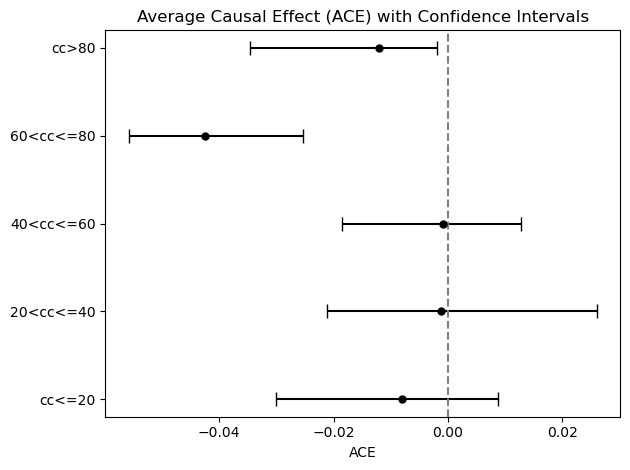

In [72]:
ate_dict_forestcoverage = construct_ate_dict(forest_cover_classes, "40<cc<=60")

for fcc in forest_cover_classes:

    effect_median, effect_interval = gcm.confidence_intervals(
                gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                    causal_model, "fire", 
                                    interventions_alternative={'forest_coverage': lambda x: fcc},
                                    interventions_reference={'forest_coverage': lambda x: ate_dict_forestcoverage["ref_value"]},
                                    observed_data=train_data))
    
    ate_dict_forestcoverage["ate"][fcc]["median"] = effect_median[0]
    ate_dict_forestcoverage["ate"][fcc]["interval"] = effect_interval[0]

plot_ate_with_confidence(ate_dict_forestcoverage, r"../results/ate_forest_cover_without_FFMC.png")

In [73]:
ate_dict_forestcoverage

{'ref_value': '40<cc<=60',
 'ate': {'cc<=20': {'median': -0.007990867579908679,
   'interval': array([-0.03013699,  0.00872653])},
  '20<cc<=40': {'median': -0.0012635869819481813,
   'interval': array([-0.02110604,  0.0260274 ])},
  '40<cc<=60': {'median': -0.0009181237464757428,
   'interval': array([-0.01851852,  0.01283612])},
  '60<cc<=80': {'median': -0.04241523043121123,
   'interval': array([-0.05580923, -0.0253171 ])},
  'cc>80': {'median': -0.012067976803057873,
   'interval': array([-0.03465246, -0.00190259])}}}

### Evaluation Causal Estimates

In [128]:
def calculate_adjustment_value(row,
                               ace_population: dict, 
                               ace_exposition: dict, 
                               ace_foresttype: dict) -> float:
    ace_pop = ace_population["ate"][row.population]["median"]
    ace_exp = ace_exposition["ate"][row.exposition]["median"]
    ace_ft = ace_foresttype["ate"][row.forest_type]["median"]    
    return ace_pop + ace_exp + ace_ft

In [132]:
# read in test data
path_to_test_data = r"../data/data_prep/data_test.csv"
test_data = pd.read_csv(path_to_test_data)

cols_of_interest = ["population", "forest_type", "exposition", "ffmc", "fire"]
test_data_slim = test_data.loc[:, cols_of_interest]

In [133]:
test_data_slim["ffmc_adjustment_index"] = test_data_slim.apply(lambda row: calculate_adjustment_value(row, ate_dict_population, 
                                                                                                           ate_dict_exposition, 
                                                                                                           ate_dict_foresttype), axis=1)

In [167]:
test_data_slim["ffmc_adjustment_index"].sum()

In [159]:
path_to_pop_layer = "/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/processed/population_data/population_2021_layer.tif"
path_to_ft_layer = "/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/processed/forest_type/forest_type_layer.tif"
path_to_exp_layer = "/home/david/Documents/Projects/ignite-wildfire-ignition-prediction/data/processed/topographical_data/aspect_layer.tif"

with rasterio.open(path_to_pop_layer) as src:
    pop_layer = src.read() 

with rasterio.open(path_to_ft_layer) as src:
    ft_layer = src.read() 

with rasterio.open(path_to_exp_layer) as src:
    exp_layer = src.read() 


In [164]:
pop_layer.max()

### Prediction 

In [136]:
def map_str_to_int(x):
    return 1 if x == "Yes" else 0

In [137]:
# read in test data
path_to_test_data = r"../data/data_prep/data_test.csv"
test_data = pd.read_csv(path_to_test_data)

In [147]:
scenario = {
    "elevation": lambda x: "800-1500",
    "exposition": lambda x: "S",
    "slope": lambda x: "10-20",
    "farmyard": lambda x: "No",
    "forestroad": lambda x: "No",
    "railway": lambda x: "No",
    "hikingtrail": lambda x: "No",
    "population": lambda x: "0-50 P/km2",
    "forest_type": lambda x: "pine pure",
    "forest_coverage": lambda x: "cc>80"
}

samples = gcm.interventional_samples(causal_model,
                                        scenario,
                                        num_samples_to_draw=1000)


fire = samples.fire.apply(map_str_to_int)
print(np.mean(fire))
print(np.std(fire))

0.826
0.3791094828674163


In [139]:
def make_prediction(row):

    scenario = {
        "elevation": lambda x: row.elevation,
        "exposition": lambda x: row.exposition,
        "slope": lambda x: row.slope,
        "farmyard": lambda x: row.farmyard,
        "forestroad": lambda x: row.forestroad,
        "railway": lambda x: row.railway,
        "hikingtrail": lambda x: row.hikingtrail,
        "population": lambda x: row.population,
        "forest_type": lambda x: row.forest_type,
        "forest_coverage": lambda x: row.forest_coverage
    }

    samples = gcm.interventional_samples(causal_model,
                                         scenario,
                                         num_samples_to_draw=1000)
    
    fire = samples.fire.apply(map_str_to_int)
    return np.mean(fire)

In [140]:

y_pred = test_data.apply(lambda row: make_prediction(row), axis=1).values
y_pred_bin = np.where(np.array(y_pred) > 0.5, 1, 0)
y_true = test_data.fire.apply(map_str_to_int).values

print(accuracy_score(y_true, y_pred_bin))
print(f1_score(y_true, y_pred_bin))

0.7214611872146118
0.7644787644787646
